[안진용] 원본이미지에서 배경을 제거한 이미지로 mobilenetv3 모델 돌림

In [17]:
import os
import tensorflow as tf
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from pathlib import Path

In [18]:
# 데이터 경로 설정
base_path = Path("/aiffel/aiffel/jellyfish")
train_dir = base_path / "jellyfish_background_remove"

# 모든 이미지 파일 경로와 레이블 수집
all_files = list(train_dir.rglob("*.jpg"))  # 모든 jpg 파일 경로 수집
file_paths = [str(f) for f in all_files]  # 경로를 문자열로 변환
labels = [f.parent.name for f in all_files]  # 상위 디렉토리 이름을 레이블로 사용


In [19]:
# 클래스 비율을 유지하며 Train(80%) vs Temp(20%) 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Temp 데이터를 Validation(10%) vs Test(10%)로 분할
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train 데이터: {len(X_train)}개")
print(f"Validation 데이터: {len(X_val)}개")
print(f"Test 데이터: {len(X_test)}개")


Train 데이터: 720개
Validation 데이터: 90개
Test 데이터: 90개


In [20]:
# 클래스 이름 정의 및 매핑 생성
class_names = sorted(set(labels))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

# 이미지를 로드하고 전처리하는 함수 정의
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224], method='bilinear')  # MobileNetV3 입력 크기
    return tf.keras.applications.mobilenet_v3.preprocess_input(img)
    
# TensorFlow Dataset 생성 함수 정의
def create_tf_dataset(paths, labels):
    labels = [class_to_idx[label] for label in labels]  # 레이블을 인덱스로 변환
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda p, l: (load_image(p), l))  # 이미지 로드 및 전처리 적용
    return dataset

# Train/Validation/Test 데이터셋 생성
train_ds = create_tf_dataset(X_train, y_train).shuffle(1000).batch(32).prefetch(2)
valid_ds = create_tf_dataset(X_val, y_val).batch(32).prefetch(2)
test_ds = create_tf_dataset(X_test, y_test).batch(32)


In [21]:
# MobileNetV3Large 모델 로드 및 고정 (전이 학습)
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet'
)
base_model.trainable = False  # 사전 학습된 가중치 고정

# 사용자 정의 분류기 추가
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # 클래스 수에 맞게 출력층 설정
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
]


In [23]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
23/23 [==============================] - 6s 89ms/step - loss: 1.2133 - accuracy: 0.6083 - val_loss: 0.6145 - val_accuracy: 0.8333
Epoch 2/15
23/23 [==============================] - 2s 43ms/step - loss: 0.3609 - accuracy: 0.8764 - val_loss: 0.4007 - val_accuracy: 0.8889
Epoch 3/15
23/23 [==============================] - 2s 43ms/step - loss: 0.2165 - accuracy: 0.9333 - val_loss: 0.3163 - val_accuracy: 0.9000
Epoch 4/15
23/23 [==============================] - 2s 44ms/step - loss: 0.1571 - accuracy: 0.9500 - val_loss: 0.2606 - val_accuracy: 0.9111
Epoch 5/15
23/23 [==============================] - 2s 43ms/step - loss: 0.1136 - accuracy: 0.9639 - val_loss: 0.2239 - val_accuracy: 0.9222
Epoch 6/15
23/23 [==============================] - 2s 44ms/step - loss: 0.0919 - accuracy: 0.9778 - val_loss: 0.1798 - val_accuracy: 0.9444
Epoch 7/15
23/23 [==============================] - 2s 43ms/step - loss: 0.0651 - accuracy: 0.9847 - val_loss: 0.1725 - val_accuracy: 0.9333
Epoch 8/15
23

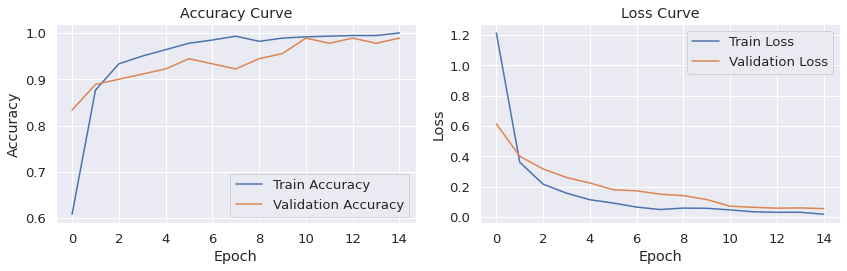

In [24]:
plt.figure(figsize=(12, 4))

# 정확도 곡선 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 곡선 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"테스트 손실: {test_loss:.4f}")
print(f"테스트 정확도: {test_acc:.4f}")


3/3 [==============================] - 0s 42ms/step - loss: 0.1828 - accuracy: 0.9333
테스트 손실: 0.1828
테스트 정확도: 0.9333


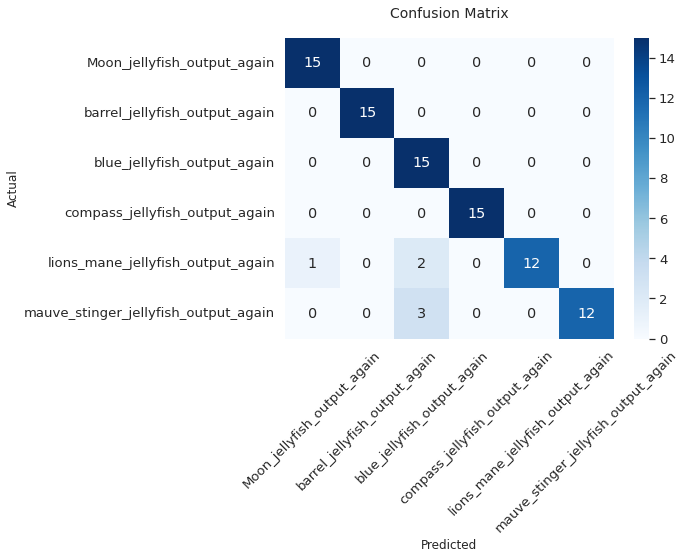

In [26]:
# 테스트 데이터 예측
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 레이블 추출
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred_classes)

# 시각화
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # 글자 크기 조정 추가
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,  
                yticklabels=class_names)  
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # X축 라벨 회전 추가
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)   # Y축 라벨 정렬
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', pad=20, fontsize=14)
plt.tight_layout()  # 레이아웃 조정
plt.show()

# 테스트용 무작위 이미지 예측

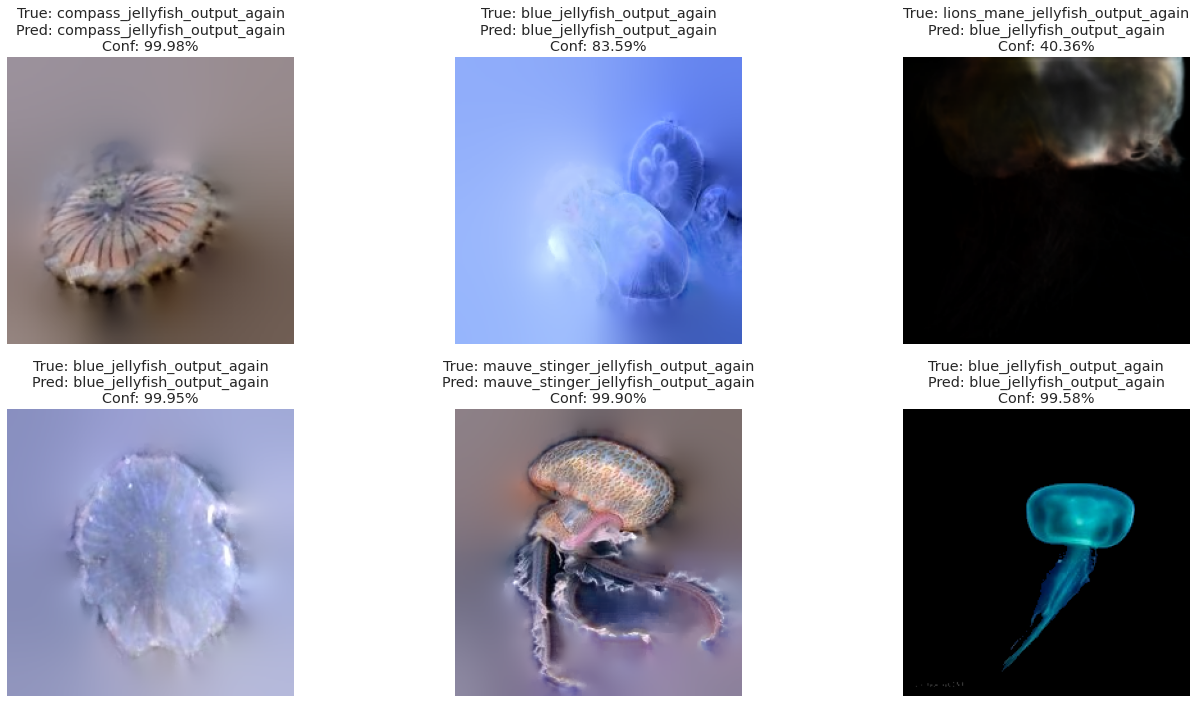

In [27]:
def predict_image(image_path):
    img = load_image(image_path)
    img = tf.expand_dims(img, axis=0)  # 배치 차원 추가
    prediction = model.predict(img)
    predicted_idx = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    return class_names[predicted_idx], confidence

def predict_random_images(num_samples=6):
    # 무작위 샘플 선택
    random_indices = random.sample(range(len(X_test)), num_samples)
    selected_paths = [X_test[i] for i in random_indices] # 테스트용 이미지 경로들의 리스트
    true_labels = [y_test[i] for i in random_indices] # 실제 레이블 리스트

    # 시각화 설정
    plt.figure(figsize=(20, 10))
    
    for i, (path, true_label) in enumerate(zip(selected_paths, true_labels)):
        # 예측 수행
        predicted_class, confidence = predict_image(path)
        
        # 원본 이미지 로드 
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img.numpy().astype("uint8")

        # 결과 시각화
        plt.subplot(2, 3, i+1) 
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.2%}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 6개 이미지 예측 실행
predict_random_images(6)


#  다른 폴더에서 가져온 무작위 해파리 사진 예측

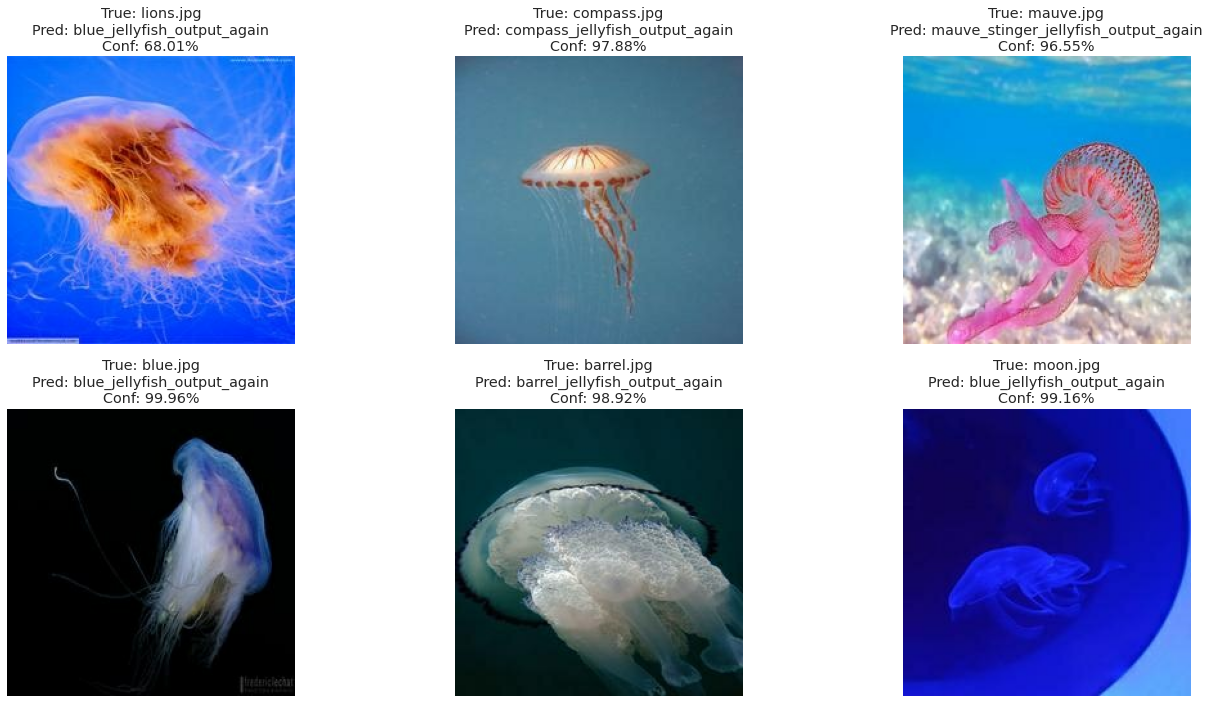

In [28]:
# 새로운 폴더 경로 설정
NEW_FOLDER_PATH = "/aiffel/aiffel/jellyfish/predict"  # 예: "./new_images"

def load_images_and_labels_from_folder(folder_path):
    image_paths = []
    true_labels = []

    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = fname.split('_')[0] 
            image_paths.append(os.path.join(folder_path, fname))
            true_labels.append(label)

    return image_paths, true_labels

def predict_random_images_with_true_labels(folder_path, num_samples=5):
    # 새로운 폴더에서 이미지와 레이블 로드
    image_paths, true_labels = load_images_and_labels_from_folder(folder_path)

    # 무작위 샘플 선택
    random_indices = random.sample(range(len(image_paths)), num_samples)
    selected_paths = [image_paths[i] for i in random_indices]
    selected_true_labels = [true_labels[i] for i in random_indices]

    # 시각화 설정
    plt.figure(figsize=(20, 10))
    
    for i, (path, true_label) in enumerate(zip(selected_paths, selected_true_labels)):
        # 예측 수행
        predicted_class, confidence = predict_image(path)
        
        # 원본 이미지 로드 
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img.numpy().astype("uint8")

        # 결과 시각화
        plt.subplot(2, 3, i+1) 
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.2%}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 새로운 폴더에서 6개 이미지 예측 실행
predict_random_images_with_true_labels(NEW_FOLDER_PATH, num_samples=6)
